In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import holidays

In [76]:
df_cons = pd.read_excel('datasets/Actual_consumption_202001010000_202011242359.xlsx', skiprows=6,na_values='-')
df_price = pd.read_excel('datasets/Day-ahead_prices_202001010000_202011242359.xlsx', skiprows=6, na_values='-')
df_gen = pd.read_excel('datasets/Actual_generation_202001010000_202011242359.xlsx', skiprows=6, na_values='-')



#Concatenate Date + Time and create TimeSeries
df_cons['Date'] = pd.to_datetime(df_cons['Date'] + ' ' + df_cons['Time of day'])
#Create Timeseries index for 
df_cons['Date'] = df_cons['Date'].dt.tz_localize('Europe/Berlin', ambiguous='infer')
#Drop Unused column
df_cons.drop('Time of day', axis=1, inplace=True)
#Create Timeseries index for
df_cons.set_index('Date', inplace=True)
#Convert to GWh for better Visualization
df_cons['Total[MWh]']/=1000
df_cons.rename(columns={'Total[MWh]': 'TotalConsumption[GWh]'}, inplace=True)

#Repeat the same steps for Prices Dataset
df_price['Date'] = pd.to_datetime(df_price['Date'] + ' ' + df_price['Time of day'])
df_price['Date'] = df_price['Date'].dt.tz_localize('Europe/Berlin', ambiguous='infer')
df_price.set_index('Date', inplace=True)
df_price.drop(df_price.columns[[0,2,3,4,5,6,7,8,9,10,11,12,13,14]], axis=1, inplace=True)
#Remove Market Signals
df_price['Germany/Luxembourg[€/MWh]'] = df_price[df_price['Germany/Luxembourg[€/MWh]'] > 1]

#Repeat the same steps for Power Generation Dataset 
df_gen['Date'] = pd.to_datetime(df_gen['Date'] + ' ' + df_gen['Time of day'])
df_gen['Date'] = df_gen['Date'].dt.tz_localize('Europe/Berlin', ambiguous='infer')
df_gen.drop('Time of day', axis=1, inplace=True)
df_gen.set_index('Date', inplace=True)

#Create the Total Power Generation Column also known as Sypply
df_gen['TotalGeneration[MWh]'] = (df_gen['Biomass[MWh]'] + 
        df_gen['Hydropower[MWh]']+
        df_gen['Wind offshore[MWh]'] +
        df_gen['Wind onshore[MWh]']+
        df_gen['Photovoltaics[MWh]']+
        df_gen['Other renewable[MWh]']+ 
        df_gen['Nuclear[MWh]']+ 
        df_gen['Fossil brown coal[MWh]']+
        df_gen['Fossil hard coal[MWh]']+ 
        df_gen['Fossil gas[MWh]']+ 
        df_gen['Hydro pumped storage[MWh]']+
        df_gen['Other conventional[MWh]'])

#Convert all columns to GWh
df_gen['TotalGeneration[MWh]']/=1000  
df_gen['Biomass[MWh]']/=1000
df_gen['Hydropower[MWh]']/=1000
df_gen['Wind offshore[MWh]']/=1000
df_gen['Wind onshore[MWh]']/=1000
df_gen['Photovoltaics[MWh]']/=1000
df_gen['Other renewable[MWh]']/=1000
df_gen['Nuclear[MWh]']/=1000
df_gen['Fossil brown coal[MWh]']/=1000
df_gen['Fossil hard coal[MWh]']/=1000
df_gen['Fossil gas[MWh]']/=1000
df_gen['Hydro pumped storage[MWh]']/=1000
df_gen['Other conventional[MWh]']/=1000

df_gen.rename(columns={'TotalGeneration[MWh]': 'TotalGeneration[GWh]',
                       'Biomass[MWh]':'Biomass[GWh]',
                       'Hydropower[MWh]': 'Hydropower[GWh]',
                       'Wind offshore[MWh]': 'Wind offshore[GWh]',
                       'Wind onshore[MWh]':'Wind onshore[GWh]',
                       'Photovoltaics[MWh]':'Photovoltaics[GWh]',
                       'Other renewable[MWh]':'Other renewable[GWh]',
                       'Nuclear[MWh]':'Nuclear[GWh]',
                       'Fossil brown coal[MWh]':'Fossil brown coal[GWh]',
                       'Fossil hard coal[MWh]':'Fossil hard coal[GWh]',
                       'Fossil gas[MWh]':'Fossil gas[GWh]',
                       'Hydro pumped storage[MWh]':'Hydro pumped storage[GWh]',
                       'Other conventional[MWh]':'Other conventional[GWh]'                      
                      }, inplace=True)


#Downsample datasets to a daily frequency 
df_dcons = df_cons.resample('D').sum()
df_dgen = df_gen.resample('D').sum()
df_dprice = df_price.resample('D').median()

#Merge Datasets into a single one
df = pd.merge(df_dcons, df_dgen, left_index=True, right_index=True )
df = pd.merge(df, df_dprice, left_index=True, right_index=True )

#Calculate Non-base Demand According to the chosen paper
df['Non-base Demand[GWh]'] = df['TotalConsumption[GWh]'] - df['Hydropower[GWh]'] - df['Nuclear[GWh]']
#Calculate Supply-Demand Index
df['SDI'] = (df['TotalGeneration[GWh]'] - df['TotalConsumption[GWh]'])/ df['TotalConsumption[GWh]']*100

#Get weekday
df['DoW'] = df.index.dayofweek

#Get holidays in Germany
de_holidays = holidays.DEU()
df['Weekend/Holiday'] = df.apply(lambda x: x.name in de_holidays or x.DoW in [5,6], axis=1)

In [78]:
df.tail()

,TotalConsumption[GWh],Residual load[MWh],Biomass[GWh],Hydropower[GWh],Wind offshore[GWh],Wind onshore[GWh],Photovoltaics[GWh],Other renewable[GWh],Nuclear[GWh],Fossil brown coal[GWh],Fossil hard coal[GWh],Fossil gas[GWh],Hydro pumped storage[GWh],Other conventional[GWh],TotalGeneration[GWh],Germany/Luxembourg[€/MWh],Non-base Demand[GWh],SDI,DoW,Weekend/Holiday
Date,,,,,,,,,,,,,,,,,,,,
2020-11-20 00:00:00+01:00,1456.334,1063987.0,108.907,38.048,88.599,251.196,52.586,5.002,161.355,349.600,151.989,227.037,31.988,33.973,1500.280,46.360,1256.931,3.017577,4,False
2020-11-21 00:00:00+01:00,1274.933,549103.0,108.326,34.662,111.860,562.890,51.107,5.014,150.652,198.235,77.045,121.443,18.710,32.531,1472.475,28.520,1089.619,15.494304,5,True
2020-11-22 00:00:00+01:00,1191.432,550191.0,108.687,29.982,128.318,466.972,45.987,4.841,150.561,236.946,91.130,122.579,16.324,32.545,1434.872,27.815,1010.889,20.432555,6,True
2020-11-23 00:00:00+01:00,1449.361,941667.0,108.946,34.791,135.529,326.631,45.218,4.910,158.168,359.305,194.693,255.763,28.385,25.021,1677.360,45.230,1256.402,15.731001,0,False
2020-11-24 00:00:00+01:00,639.349,413985.0,108.207,38.557,126.988,264.824,36.607,5.045,152.516,383.538,232.769,263.155,28.051,25.684,1665.941,42.805,448.276,160.568328,1,False


<AxesSubplot:xlabel='Date'>

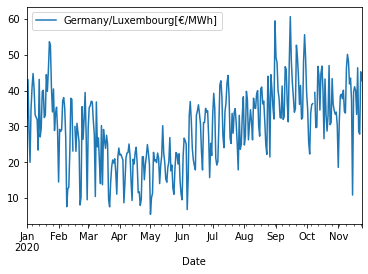

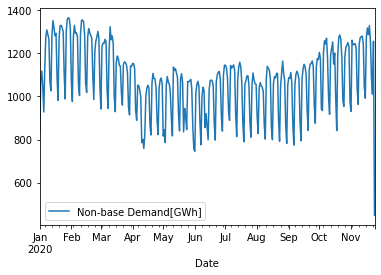

In [22]:
df[['Germany/Luxembourg[€/MWh]']].plot()
df[['Non-base Demand[GWh]']].plot()

<AxesSubplot:xlabel='Date'>

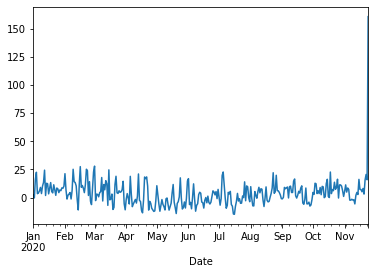

In [23]:
df['SDI'].plot()